<a href="https://colab.research.google.com/github/the-ml-bull/Hello_World/blob/main/6_Measurement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime

def load_data():
  url = 'https://raw.githubusercontent.com/the-ml-bull/Hello_World/main/Fx60.csv'
  dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M')

  df = pd.read_csv(url, parse_dates=['date'], date_parser=dateparse)

  return df

In [1]:
def create_xy_values(df, feature_names):

    # create new holder for all values
    x_values_df = pd.DataFrame()

    #
    # X values look back
    #

    # loop thorugh feature name and "back periods" to go back
    x_feature_names = []
    for feature in feature_names:
        for period in [1,2,3,4]:
            # create the name (eg 'x_audusd_close_t-1')
            feature_name = 'x_' + feature + '_t-' + str(period)
            x_feature_names.append(feature_name)
            x_values_df[feature_name] = df[feature].shift(period)

    # Add "starting" values when used in normalization and date for reference
    x_values_df['date'] = df['date']
    x_values_df['x_audusd_open'] = df['audusd_open'].shift(4)
    x_values_df['x_eurusd_open'] = df['eurusd_open'].shift(4)
    x_values_df['audusd_open'] = df['audusd_open']
    x_values_df['eurusd_open'] = df['eurusd_open']

    #
    # Y values look forward
    #

    # add all future y values for future periods
    # set y=1 for >= 200 points
    # set y=-1 for <= -150 (for later use)
    # set y=0 for all else
    # set y_points to actual points finished with (for later calculation of profit)

    x_values_df['y'] = -2       # start wtih -2 to search for not -1,0,1
    x_values_df['y_points'] = 0   # start with no point movement
    for period in [0,1,2,3]:    # loop thorugh each forward period in y (4 forward periods)

        # names to store future price and change points
        name = 'y_t-' + str(period)                         #name of future y value
        price_name = 'y_change_price_' + str(period)        # name of future y points change
        points_name = 'y_change_points_' + str(period)      # name of future y points change

        # add important future values to spreadsheet
        x_values_df[name] = df['audusd_close'].shift(-period)
        x_values_df[name + '_low'] = df['audusd_low'].shift(-period)
        x_values_df[name + '_high'] = df['audusd_high'].shift(-period)

        # calculate change in points
        x_values_df[price_name] = x_values_df[name] - df['audusd_open']
        x_values_df[points_name] = x_values_df[price_name] * 100000
        x_values_df[price_name + '_low'] = x_values_df[name + '_low'] - df['audusd_open']
        x_values_df[points_name + '_low'] = x_values_df[price_name + '_low'] * 100000
        x_values_df[price_name + '_high'] = x_values_df[name + '_high'] - df['audusd_open']
        x_values_df[points_name + '_high'] = x_values_df[price_name + '_high'] * 100000

        # get and calculate all "down" values where y isnt already set
        # down "down" first, for case where bar goes both up and down in the same period assume down first (worst case for profit)
        down_df = x_values_df[(x_values_df['y'] == -2) & (x_values_df[points_name + '_low'] <= -150)]
        x_values_df.loc[down_df.index, 'y']  = -1
        x_values_df.loc[down_df.index, 'y_points'] = -150
        x_values_df.loc[down_df.index, 'y_finish_period'] = period

        # get and calculate all "up" vales where y isnt already set
        up_df = x_values_df[(x_values_df['y'] == -2) & (x_values_df[points_name + '_high'] >= 200)]
        x_values_df.loc[up_df.index, 'y'] = 1
        x_values_df.loc[up_df.index, 'y_points'] = 200
        x_values_df.loc[up_df.index, 'y_finish_period'] = period

    # if no period triggered tp/sl then no movement (y=0) and points are whatever it is at the end of the period
    none_df = x_values_df[x_values_df['y'] == -2]
    x_values_df.loc[none_df.index, 'y']  = 0
    x_values_df.loc[none_df.index, 'y_points'] = x_values_df[points_name]
    x_values_df.loc[none_df.index, 'y_finish_period'] = 3

    # set down (currently -1) to 0 since we arent using it (yet - we will later)
    x_values_df.loc[x_values_df[x_values_df['y'] == -1].index, 'y']  = 0

    # if points exceeds tp or sl then reset to sl/tp since these limits are fixed in trading
    x_values_df.loc[x_values_df['y_points'] < -150, 'y_points'] = -150
    x_values_df.loc[x_values_df['y_points'] > 200, 'y_points'] = 200

    # and reset df (avoids indexing complications later) and done
    x_values_df = x_values_df.copy()

    return x_values_df, x_feature_names


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def normalize_data(df, x_fields, method):

  norm_df = df.copy()
  y_fields = ['y_t-0', 'y_t-1', 'y_t-2', 'y_t-3']

  if method == 'price':
    for field in x_fields:
      norm_df[field + '_norm'] = df[field]

    for field in y_fields:
      norm_df[field + '_norm'] = df[field]

  if method == 'points':
    for field in x_fields:
      if 'volume' in field:
        norm_df[field + '_norm'] = df[field] / 100
      elif 'audusd' in field:
        norm_df[field + '_norm'] = (df[field] - df['x_audusd_open']) * 100000
      elif 'eurusd' in field:
        norm_df[field + '_norm'] = (df[field] - df['x_eurusd_open']) * 100000

    for field in y_fields:
      norm_df[field + '_norm'] = (df[field] -  df['audusd_open']) * 100000

  if method == 'percentage':
    for field in x_fields:
      if 'volume' in field:
        norm_df[field + '_norm'] = df[field] / 10000
      elif 'audusd' in field:
        norm_df[field + '_norm'] = (df[field] - df['x_audusd_open']) / df[field] * 100
      elif 'eurusd' in field:
        norm_df[field + '_norm'] = (df[field] - df['x_eurusd_open']) / df[field] * 100

    for field in y_fields:
      norm_df[field + '_norm'] = (df[field] - df['audusd_open']) / df[field] * 100

  if method == 'minmax':
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[x_fields + y_fields])
    norm_field_names = [x + '_norm' for x in x_fields + y_fields]
    norm_df[norm_field_names] = scaled

  if method == 'stddev':
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df[x_fields + y_fields])
    norm_field_names = [x + '_norm' for x in x_fields + y_fields]
    norm_df[norm_field_names] = scaled

  x_feature_names_norm = [x + '_norm' for x in x_fields]
  return norm_df, x_feature_names_norm

In [12]:
def get_train_val(df, x_feature_names_norm):
  #
  # Create Train and Val datasets
  #

  x = df[x_feature_names_norm]
  y = df['y']
  y_points = df['y_points']

  # Note Fx "follows" (time series) so randomization is NOT a good idea
  # create train and val datasets.
  no_train_samples = int(len(x) * 0.7)
  x_train = x[4:no_train_samples]
  y_train = y[4:no_train_samples]

  x_val = x[no_train_samples:-3]
  y_val = y[no_train_samples:-3]
  y_val_change_points = y_points[no_train_samples:-3]

  return x_train, y_train, x_val, y_val, y_val_change_points, no_train_samples

In [6]:
def get_class_weights(y_train, display=True):

  #
  # Create class weights
  #
  from sklearn.utils.class_weight import compute_class_weight

  num_ones = np.sum(y_train)
  num_zeros = len(y_train) - num_ones

  classes = np.unique(y_train)
  class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
  class_weights = dict(zip(classes, class_weights))

  if display:
    print('In the training set we have 0s {} ({:.2f}%), 1s {} ({:.2f}%)'.format(num_zeros, num_zeros/len(y_train)*100, num_ones, num_ones/len(y_train)*100))
    print('class weights {}'.format(class_weights))

  return class_weights

In [7]:
from sklearn.metrics import log_loss, confusion_matrix, precision_score, recall_score, f1_score

def divide(a, b):

  a = np.asarray(a).astype(float)
  b = np.asarray(b).astype(float)

  result = np.divide(a, b, out=np.zeros_like(a), where=b != 0)
  return result

def show_metrics(lr, x, y_true, y_points, display=True):

  # predict from teh val set meas we have predictions and true values as binaries
  y_pred = lr.predict(x)

  #basic error types
  log_loss_error = log_loss(y_true, y_pred)
  score = lr.score(x, y_true)

  #
  # Customized metrics to confusion matrix
  #
  tp = np.where((y_pred == 1) & (y_points >= 0), 1, 0).sum()
  fp = np.where((y_pred == 1) & (y_points < 0), 1, 0).sum()
  tn = np.where((y_pred == 0) & (y_points < 0), 1, 0).sum()
  fn = np.where((y_pred == 0) & (y_points >= 0), 1, 0).sum()

  # derived from confusion matrix
  precision = float(divide(tp, (tp+fp)))
  recall = float(divide(tp, (tp + fn)))
  f1 = float(divide((precision*recall), (precision + recall)))

  # profit calculation
  profit = np.where(y_pred==1, y_points, 0).sum()

  # output the errors
  if display:
    print('Errors Loss: {:.4f}'.format(log_loss_error))
    print('Errors Score: {:.2f}%'.format(score*100))
    print('Errors tp: {} ({:.2f}%)'.format(tp, tp/len(y_val)*100))
    print('Errors fp: {} ({:.2f}%)'.format(fp, fp/len(y_val)*100))
    print('Errors tn: {} ({:.2f}%)'.format(tn, tn/len(y_val)*100))
    print('Errors fn: {} ({:.2f}%)'.format(fn, fn/len(y_val)*100))
    print('Errors Precision: {:.2f}%'.format(precision*100))
    print('Errors Recall: {:.2f}%'.format(recall*100))
    print('Errors F1: {:.2f}'.format(f1*100))
    print('profit: {:.2f} points'.format(profit))

  errors = {
      'loss': log_loss_error,
      'score': score,
      'tp': tp,
      'fp': fp,
      'tn': tn,
      'fn': fn,
      'precision': precision,
      'recall': recall,
      'f1': f1,
      'profit': profit
      }

  return errors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 4.4 MB/s eta 0:00:00


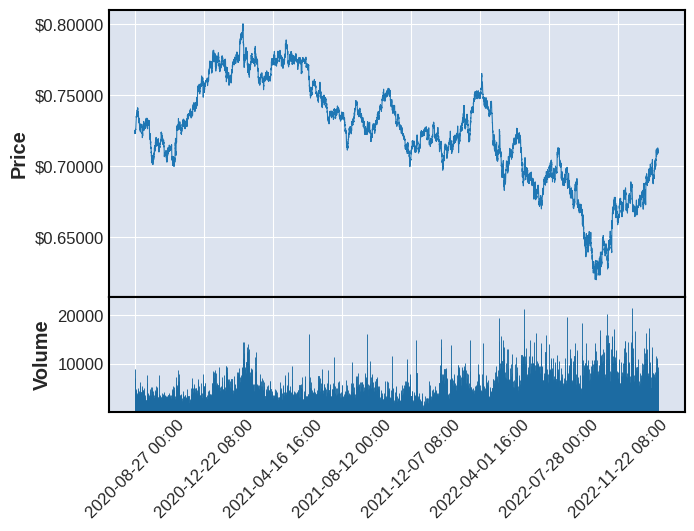

In [8]:
#
# Code to plot val data price movement.  Val data starts from index 35373 which is 2020-08-07 7:00
#

#!pip install mplfinance
import mplfinance as mpf

df = load_data()

# create DF and copy values from main df
mpf_df = pd.DataFrame()
mpf_df[['date', 'Open', 'High', 'Low', 'Close', 'Volume']] = df[['date', 'audusd_open', 'audusd_high', 'audusd_low', 'audusd_close', 'audusd_volume']].to_numpy()

# set index to datetime index date
mpf_df['date'] = pd.to_datetime(mpf_df['date'])
mpf_df = mpf_df.set_index('date')

# set OHLC as float
mpf_df = mpf_df[['Open', 'High', 'Low', 'Close', 'Volume']].astype(float)

from matplotlib.ticker import FormatStrFormatter
fig, axlist = mpf.plot(mpf_df['2020-08-27':], volume=True, datetime_format='%Y-%m-%d %H:%M', type='line', returnfig=True)
axlist[0].yaxis.set_major_formatter(FormatStrFormatter('$%.5f'))
mpf.show()

In [15]:
#
# To calculate trades
#
def get_trades(lr, x, y_change_points):

  y_pred = lr.predict(x)

  trades = []
  for ix in range(len(y_pred)):

    if y_pred[ix] == 1:
      won = False
      profit = y_change_points.iloc[ix]

      if profit > 0:
        won = True

      trades.append([ix, won, profit])

  trades_df = pd.DataFrame(trades, columns=['ix', 'won', 'profit'])

  return trades_df



In [13]:
#
# To chart trades
#
def chart_trades(trades, features_df, raw_df, number_of_charts):

  rows = math.ceil(number_of_charts / 3)
  fig, axes = plt.subplots(nrows=rows, ncols=3)

  for chart_ix in range(number_of_charts):

    # get indexes and ate for chart
    trade_ix = random.randint(0, len(trades))
    data_ix = trades['ix'].iloc[trade_ix] + 35373
    date = features_df['date'].iloc[data_ix]

    # prepard data for OHLC candles
    mpf_df = pd.DataFrame()
    mpf_df[['date', 'Open', 'High', 'Low', 'Close', 'Volume']] = \
      raw_df[['date', 'audusd_open', 'audusd_high', 'audusd_low', 'audusd_close', 'audusd_volume']] \
      .iloc[data_ix-4:data_ix+4].to_numpy()
    mpf_df['date'] = pd.to_datetime(mpf_df['date'])
    mpf_df = mpf_df.set_index('date')
    mpf_df = mpf_df[['Open', 'High', 'Low', 'Close', 'Volume']].astype(float)

    # plot the chart
    ax = axes.flatten()[chart_ix]
    mpf.plot(mpf_df, ax=ax, volume=False, datetime_format='', type='candle')

    # add title
    ax.set_title(date.strftime('%d-%m-%Y %H:%M'))

    # add marker to seperate history and future
    ax.plot([4, 4], [mpf_df['High'].iloc[4], ax.get_ylim()[1]],  color='y', marker='o', linewidth=3.0)
    ax.plot([4, 4], [ax.get_ylim()[0], mpf_df['Low'].iloc[4]],  color='y', marker='o', linewidth=3.0)

    # horizontal lines indicator tp and sl
    open_price = mpf_df['Open'].iloc[4]
    ax.axhline(open_price+(200/100000), color='green', linewidth=1.5)
    ax.axhline(open_price-(150/100000), color='red', linewidth=1.5)

    # plot line from start to close position
    close_period = int(features_df['y_finish_period'].iloc[data_ix])
    profit = features_df['y_points'].iloc[data_ix]
    close_price = open_price + (profit / 100000)
    ax.plot([4,4+close_period], [mpf_df['Open'].iloc[4], close_price], color='r', marker='x', linewidth=1.5)

    # text box indicating result
    txt = 'Win: {}\nProfit: {:.2f}\nExit: {}'.format(trades.iloc[trade_ix]['won'], trades.iloc[trade_ix]['profit'], close_period)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.75, txt, style='italic', transform=ax.transAxes, size=10, bbox=props)

  plt.show()
  return



In [18]:
#
# To check general bar movement
#
def check_simultaneous_sl_tp(trades_df, features_df, raw_df):

  trade_ixs = trades_df['ix'].tolist()
  results = []

  for ix in range(35373, len(features_df)):

    low = raw_df['audusd_low'].iloc[ix]
    high = raw_df['audusd_high'].iloc[ix]
    open = raw_df['audusd_open'].iloc[ix]

    points_high = round((high - open) * 100000, 2)
    points_low = round((low - open) * 100000, 2)

    gone_high, gone_low, during_trade = False, False, False

    if points_high > 200:
      gone_high = True
    if points_low < -150:
      gone_low = True
    if (ix-35373) in trade_ixs:
      during_trade = True

    results.append([ix, gone_high, gone_low, during_trade])

  results_df = pd.DataFrame(results, columns=['ix', 'high', 'low', 'trade'])

  print('Total Periods {}'.format(len(results_df)))
  print('Highs {}'.format(len(results_df[results_df['high'] == True])))
  print('Lows {}'.format(len(results_df[results_df['low'] == True])))
  print('Trades {}'.format(len(results_df[results_df['trade'] == True])))
  print('Not In Trade Highs AND Lows together {}'.format(len(results_df[(results_df['high'] == True) & (results_df['low'] == True)])))
  print('In Trade Highs AND Lows together {}'.format(len(results_df[(results_df['high'] == True) & (results_df['low'] == True) & (results_df['trade'] == True)])))

  return results_df

In [17]:
#
# Main loop to test different normalization techniques
#
for norm_method in ['price', 'points', 'percentage', 'minmax', 'stddev']:

  # load raw data
  raw_df = load_data()

  # create features
  feature_names =['audusd_open', 'audusd_close', 'audusd_high', 'audusd_low', 'audusd_volume', \
                'eurusd_open', 'eurusd_close', 'eurusd_high', 'eurusd_low', 'eurusd_volume']
  df, x_feature_names = create_xy_values(raw_df, feature_names)

  # prepare data for learning (normalize, split and class weights)
  norm_df, x_feature_names_norm = normalize_data(df, x_feature_names, method=norm_method)
  x_train, y_train, x_val, y_val, y_val_change_points, no_train_samples = get_train_val(norm_df, x_feature_names_norm)
  class_weights = get_class_weights(y_train, display=False)

  # train the model
  lr = LogisticRegression(class_weight=class_weights, max_iter=1000)
  lr.fit(x_train, y_train)
  #save_model(lr)

  # if we want to see all actual trades and chart them
  trades_df = get_trades(lr, x_val, y_val_change_points)
  print('trades {}, wins {}, profit {:.2f}'.format(len(trades_df), trades_df['won'].sum(), trades_df['profit'].sum()))

  # if we want to chart trades
  #chart_trades(trades_df, df, raw_df, number_of_charts=9)

  # if we want to check how many simultaneous tp/sl we have on our trades
  #check_simultaneous_sl_tp(trades_df, df, raw_df)

  # to show standard errors
  print('Errrors for method {}'.format(norm_method))
  errors = show_metrics(lr, x_val, y_val, y_val_change_points, display=True)


trades 5087, wins 2227, profit -29748.00
Errrors for method price
Errors Loss: 13.3041
Errors Score: 63.09%
Errors tp: 2235 (14.74%)
Errors fp: 2852 (18.82%)
Errors tn: 5214 (34.40%)
Errors fn: 4857 (32.04%)
Errors Precision: 43.94%
Errors Recall: 31.51%
Errors F1: 18.35
profit: -29748.00 points
trades 6189, wins 2697, profit -48365.00
Errrors for method points
Errors Loss: 14.7927
Errors Score: 58.96%
Errors tp: 2705 (17.85%)
Errors fp: 3484 (22.98%)
Errors tn: 4582 (30.23%)
Errors fn: 4387 (28.94%)
Errors Precision: 43.71%
Errors Recall: 38.14%
Errors F1: 20.37
profit: -48365.00 points
trades 6216, wins 2724, profit -40298.00
Errrors for method percentage
Errors Loss: 14.6571
Errors Score: 59.34%
Errors tp: 2732 (18.02%)
Errors fp: 3484 (22.98%)
Errors tn: 4582 (30.23%)
Errors fn: 4360 (28.76%)
Errors Precision: 43.95%
Errors Recall: 38.52%
Errors F1: 20.53
profit: -40298.00 points
trades 5249, wins 2308, profit -27280.00
Errrors for method minmax
Errors Loss: 13.3327
Errors Score: 6